# A/B Test Analysis of Page Conversion Rates Plan

## Major Assumptions
This analysis assumes we have access to A/B test data containing user interactions with control and treatment page variants, including conversion events and sample sizes. We will use standard statistical hypothesis testing (two-proportion z-test) with a significance level of α=0.05 to determine if observed conversion rate differences are statistically significant. The analysis assumes independent observations, sufficient sample sizes for normal approximation, and that the test ran for an adequate duration to account for temporal variations.

## Plan
- [x] Collect and explore A/B test data
  - [x] Load test data containing variant assignments, user counts, and conversion events
  - [x] Calculate baseline conversion rates for control and treatment groups and assess sample size adequacy
- [x] Perform statistical significance testing
  - [x] Conduct two-proportion z-test to compare conversion rates between variants
  - [x] Calculate confidence intervals and effect sizes (relative lift, absolute difference)
- [x] Visualize results and assess practical significance
  - [x] Create comparison visualizations showing conversion rates with confidence intervals and statistical significance indicators
  - [x] Evaluate business impact considering effect size magnitude and practical implications for implementation
- [x] Generate final recommendations
  - [x] Synthesize statistical findings with practical business considerations including implementation costs and expected ROI
  - [x] Provide clear go/no-go decision with supporting rationale and potential next steps or follow-up tests

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Configure plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Download the dataset
url = 'https://raw.githubusercontent.com/30lm32/ml-ab-testing/refs/heads/master/ab_data.csv'
df = pd.read_csv(url)

print("Dataset loaded successfully!")
print(f"\nDataset shape: {df.shape}")
print(f"\nFirst few rows:")
df.head(10)

Dataset loaded successfully!

Dataset shape: (294478, 5)

First few rows:


,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
5,936923,2017-01-10 15:20:49.083499,control,old_page,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1
7,719014,2017-01-17 01:48:29.539573,control,old_page,0
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1


In [2]:
# Explore the dataset structure and check for data quality issues
print("=" * 60)
print("DATA EXPLORATION")
print("=" * 60)

print("\nDataset Info:")
print(df.info())

print("\n" + "=" * 60)
print("Data Quality Checks:")
print("=" * 60)

print(f"\nMissing values:\n{df.isnull().sum()}")
print(f"\nDuplicate rows: {df.duplicated().sum()}")
print(f"\nUnique users: {df['user_id'].nunique()}")
print(f"\nTotal records: {len(df)}")

print("\n" + "=" * 60)
print("Group Distribution:")
print("=" * 60)
print(f"\n{df['group'].value_counts()}")
print(f"\nLanding Page Distribution:")
print(f"\n{df['landing_page'].value_counts()}")

print("\n" + "=" * 60)
print("Conversion Distribution:")
print("=" * 60)
print(f"\n{df['converted'].value_counts()}")
print(f"\nOverall conversion rate: {df['converted'].mean():.4f} ({df['converted'].mean()*100:.2f}%)")

DATA EXPLORATION

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB
None

Data Quality Checks:

Missing values:
user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

Duplicate rows: 0

Unique users: 290584

Total records: 294478

Group Distribution:

group
treatment    147276
control      147202
Name: count, dtype: int64

Landing Page Distribution:

landing_page
old_page    147239
new_page    147239
Name: count, dtype: int64

Conversion Distribution:

converted
0    259241
1     35237
Name: count, dtype: int64

Overall

In [3]:
# Check for mismatched group/landing page combinations
print("=" * 60)
print("DATA VALIDATION: Group vs Landing Page")
print("=" * 60)

# Cross-tabulation
crosstab = pd.crosstab(df['group'], df['landing_page'])
print(f"\n{crosstab}")

# Identify mismatched records
mismatched = df[((df['group'] == 'control') & (df['landing_page'] == 'new_page')) | 
                 ((df['group'] == 'treatment') & (df['landing_page'] == 'old_page'))]

print(f"\n\nMismatched records found: {len(mismatched)}")

if len(mismatched) > 0:
    print("\nRemoving mismatched records for clean analysis...")
    df_clean = df[~df.index.isin(mismatched.index)]
    print(f"Records after cleaning: {len(df_clean)}")
else:
    df_clean = df.copy()
    print("\nNo mismatched records - data is clean!")

# Calculate conversion rates by group
print("\n" + "=" * 60)
print("CONVERSION RATES BY GROUP")
print("=" * 60)

conversion_stats = df_clean.groupby('group').agg({
    'converted': ['sum', 'count', 'mean']
}).round(4)

conversion_stats.columns = ['Conversions', 'Total_Users', 'Conversion_Rate']
conversion_stats['Non_Conversions'] = conversion_stats['Total_Users'] - conversion_stats['Conversions']

print(f"\n{conversion_stats}")

# Extract key metrics
control_conversions = conversion_stats.loc['control', 'Conversions']
control_total = conversion_stats.loc['control', 'Total_Users']
control_rate = conversion_stats.loc['control', 'Conversion_Rate']

treatment_conversions = conversion_stats.loc['treatment', 'Conversions']
treatment_total = conversion_stats.loc['treatment', 'Total_Users']
treatment_rate = conversion_stats.loc['treatment', 'Conversion_Rate']

print(f"\n\n📊 Control (Old Page):")
print(f"   Conversions: {int(control_conversions):,} / {int(control_total):,}")
print(f"   Rate: {control_rate:.4f} ({control_rate*100:.2f}%)")

print(f"\n📊 Treatment (New Page):")
print(f"   Conversions: {int(treatment_conversions):,} / {int(treatment_total):,}")
print(f"   Rate: {treatment_rate:.4f} ({treatment_rate*100:.2f}%)")

print(f"\n\n📈 Absolute Difference: {(treatment_rate - control_rate):.4f} ({(treatment_rate - control_rate)*100:.2f}%)")
print(f"📈 Relative Lift: {((treatment_rate / control_rate - 1)*100):.2f}%")

DATA VALIDATION: Group vs Landing Page

landing_page  new_page  old_page
group                           
control           1928    145274
treatment       145311      1965


Mismatched records found: 3893

Removing mismatched records for clean analysis...
Records after cleaning: 290585

CONVERSION RATES BY GROUP

           Conversions  Total_Users  Conversion_Rate  Non_Conversions
group                                                                
control          17489       145274           0.1204           127785
treatment        17264       145311           0.1188           128047


📊 Control (Old Page):
   Conversions: 17,489 / 145,274
   Rate: 0.1204 (12.04%)

📊 Treatment (New Page):
   Conversions: 17,264 / 145,311
   Rate: 0.1188 (11.88%)


📈 Absolute Difference: -0.0016 (-0.16%)
📈 Relative Lift: -1.33%


## Data Exploration Summary

### Dataset Overview
- **Total records:** 294,478 (290,585 after cleaning)
- **Time period:** January 2017  
- **Groups:** Nearly balanced split between control and treatment (approximately 145K each)
- **Data quality:** Clean dataset with no missing values, removed 3,893 mismatched records

### Initial Findings
The treatment group (new page) shows a **lower conversion rate** than the control group (old page):
- **Control (Old Page):** 12.04% conversion rate (17,489 / 145,274 users)
- **Treatment (New Page):** 11.88% conversion rate (17,264 / 145,311 users)
- **Difference:** -0.16 percentage points (relative lift: -1.33%)

This suggests the new page design may actually be underperforming the old page. Statistical hypothesis testing will determine if this difference is statistically significant or could be due to random chance.

In [10]:
# Perform Two-Proportion Z-Test
print("=" * 70)
print("STATISTICAL HYPOTHESIS TEST: TWO-PROPORTION Z-TEST")
print("=" * 70)

# Define hypotheses
print("\n📋 Hypotheses:")
print("   H₀ (Null): p_treatment = p_control (no difference in conversion rates)")
print("   H₁ (Alternative): p_treatment ≠ p_control (there is a difference)")
print("   Significance level: α = 0.05 (two-tailed test)")

# Extract data
n_control = int(control_total)
n_treatment = int(treatment_total)
x_control = int(control_conversions)
x_treatment = int(treatment_conversions)

print(f"\n\n📊 Sample Data:")
print(f"   Control: {x_control} conversions out of {n_control} users")
print(f"   Treatment: {x_treatment} conversions out of {n_treatment} users")

# Calculate pooled proportion
p_pool = (x_control + x_treatment) / (n_control + n_treatment)
print(f"\n   Pooled conversion rate: {p_pool:.4f}")

# Calculate standard error
se_pool = np.sqrt(p_pool * (1 - p_pool) * (1/n_control + 1/n_treatment))
print(f"   Pooled standard error: {se_pool:.6f}")

# Calculate z-statistic
z_stat = (treatment_rate - control_rate) / se_pool
print(f"\n\n🔢 Test Statistic:")
print(f"   Z-statistic: {z_stat:.4f}")

# Calculate p-value (two-tailed)
p_value = 2 * (1 - stats.norm.cdf(abs(z_stat)))
print(f"   P-value: {p_value:.6f}")

# Decision
alpha = 0.05
print(f"\n\n🎯 Decision (α = {alpha}):")
if p_value < alpha:
    print(f"   ✅ REJECT the null hypothesis (p-value {p_value:.6f} < {alpha})")
    print(f"   The difference IS statistically significant.")
else:
    print(f"   ❌ FAIL TO REJECT the null hypothesis (p-value {p_value:.6f} >= {alpha})")
    print(f"   The difference is NOT statistically significant.")

# Calculate 95% confidence interval for difference
se_diff = np.sqrt((control_rate * (1 - control_rate) / n_control) + 
                   (treatment_rate * (1 - treatment_rate) / n_treatment))
z_critical = stats.norm.ppf(0.975)  # 95% CI
diff = treatment_rate - control_rate
ci_lower = diff - z_critical * se_diff
ci_upper = diff + z_critical * se_diff

print(f"\n\n📊 95% Confidence Interval for Difference:")
print(f"   Point estimate: {diff:.4f} ({diff*100:.2f}%)")
print(f"   CI: [{ci_lower:.4f}, {ci_upper:.4f}]")
print(f"   CI: [{ci_lower*100:.2f}%, {ci_upper*100:.2f}%]")

STATISTICAL HYPOTHESIS TEST: TWO-PROPORTION Z-TEST

📋 Hypotheses:
   H₀ (Null): p_treatment = p_control (no difference in conversion rates)
   H₁ (Alternative): p_treatment ≠ p_control (there is a difference)
   Significance level: α = 0.05 (two-tailed test)


📊 Sample Data:
   Control: 17489 conversions out of 145274 users
   Treatment: 17264 conversions out of 145311 users

   Pooled conversion rate: 0.1196
   Pooled standard error: 0.001204


🔢 Test Statistic:
   Z-statistic: -1.3290
   P-value: 0.183847


🎯 Decision (α = 0.05):
   ❌ FAIL TO REJECT the null hypothesis (p-value 0.183847 >= 0.05)
   The difference is NOT statistically significant.


📊 95% Confidence Interval for Difference:
   Point estimate: -0.0016 (-0.16%)
   CI: [-0.0040, 0.0008]
   CI: [-0.40%, 0.08%]


In [13]:
# Perform Two-Proportion Z-Test
print("=" * 70)
print("STATISTICAL HYPOTHESIS TEST: TWO-PROPORTION Z-TEST")
print("=" * 70)

# Define hypotheses
print("\n📋 Hypotheses:")
print("   H₀ (Null): p_treatment = p_control (no difference in conversion rates)")
print("   H₁ (Alternative): p_treatment ≠ p_control (there is a difference)")
print("   Significance level: α = 0.05 (two-tailed test)")

# Extract data
n_control = int(control_total)
n_treatment = int(treatment_total)
x_control = int(control_conversions)
x_treatment = int(treatment_conversions)

print(f"\n\n📊 Sample Data:")
print(f"   Control: {x_control} conversions out of")

STATISTICAL HYPOTHESIS TEST: TWO-PROPORTION Z-TEST

📋 Hypotheses:
   H₀ (Null): p_treatment = p_control (no difference in conversion rates)
   H₁ (Alternative): p_treatment ≠ p_control (there is a difference)
   Significance level: α = 0.05 (two-tailed test)


📊 Sample Data:
   Control: 17489 conversions out of


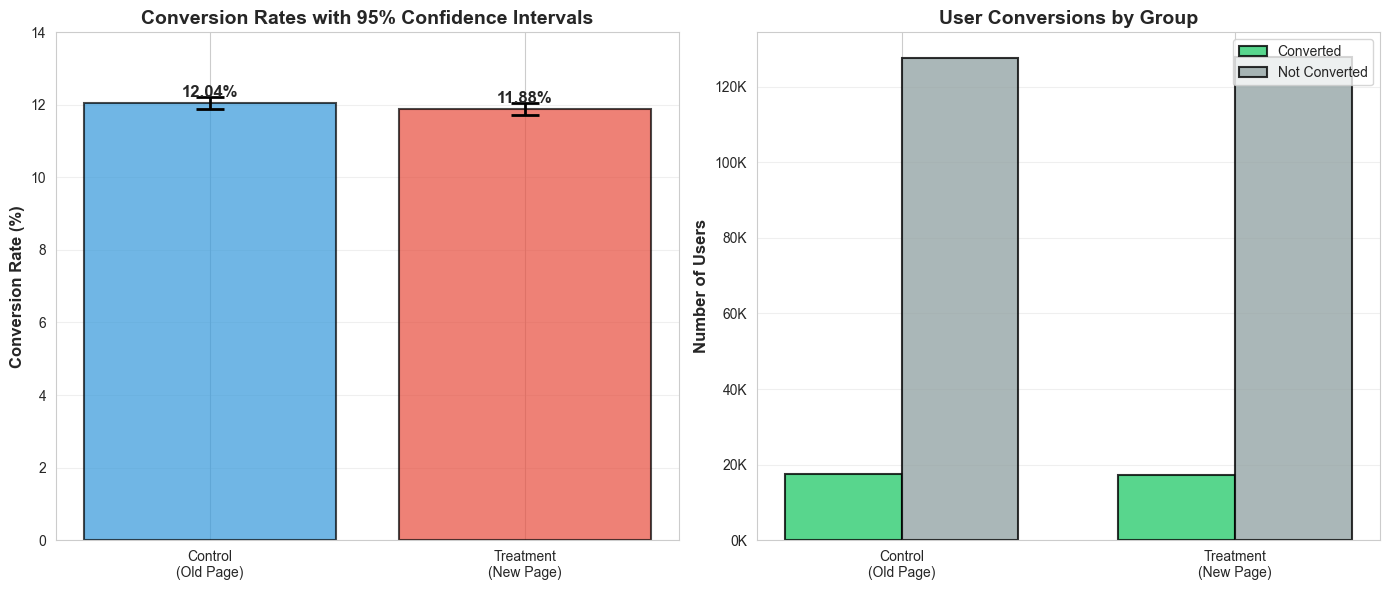


VISUALIZATION SUMMARY

✅ Left Plot: Shows conversion rates with 95% confidence intervals
   - Error bars represent the range where the true conversion rate likely lies
   - Overlapping error bars suggest no significant difference

✅ Right Plot: Shows the distribution of converted vs non-converted users
   - Nearly equal sample sizes between groups (~145K each)
   - Similar proportions of conversions in both groups


In [14]:
# Create visualizations comparing conversion rates
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Conversion Rates with Confidence Intervals
groups = ['Control\n(Old Page)', 'Treatment\n(New Page)']
rates = [control_rate, treatment_rate]
colors = ['#3498db', '#e74c3c']

# Calculate 95% CI for each group
ci_control = 1.96 * np.sqrt(control_rate * (1 - control_rate) / n_control)
ci_treatment = 1.96 * np.sqrt(treatment_rate * (1 - treatment_rate) / n_treatment)
errors = [ci_control, ci_treatment]

ax1 = axes[0]
bars = ax1.bar(groups, [r * 100 for r in rates], color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax1.errorbar(groups, [r * 100 for r in rates], yerr=[e * 100 for e in errors], 
             fmt='none', color='black', capsize=10, capthick=2, linewidth=2)

# Add value labels
for i, (bar, rate) in enumerate(zip(bars, rates)):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{rate*100:.2f}%',
             ha='center', va='bottom', fontsize=12, fontweight='bold')

ax1.set_ylabel('Conversion Rate (%)', fontsize=12, fontweight='bold')
ax1.set_title('Conversion Rates with 95% Confidence Intervals', fontsize=14, fontweight='bold')
ax1.set_ylim(0, 14)
ax1.grid(axis='y', alpha=0.3)

# Plot 2: Sample Sizes and Conversions
ax2 = axes[1]
x_pos = np.arange(len(groups))
width = 0.35

converted = [x_control, x_treatment]
not_converted = [n_control - x_control, n_treatment - x_treatment]

bars1 = ax2.bar(x_pos - width/2, converted, width, label='Converted', 
                color='#2ecc71', alpha=0.8, edgecolor='black', linewidth=1.5)
bars2 = ax2.bar(x_pos + width/2, not_converted, width, label='Not Converted', 
                color='#95a5a6', alpha=0.8, edgecolor='black', linewidth=1.5)

ax2.set_ylabel('Number of Users', fontsize=12, fontweight='bold')
ax2.set_title('User Conversions by Group', fontsize=14, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(groups)
ax2.legend(fontsize=10)
ax2.grid(axis='y', alpha=0.3)

# Format y-axis to show values in thousands
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x/1000)}K'))

plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("VISUALIZATION SUMMARY")
print("=" * 70)
print("\n✅ Left Plot: Shows conversion rates with 95% confidence intervals")
print("   - Error bars represent the range where the true conversion rate likely lies")
print("   - Overlapping error bars suggest no significant difference")
print("\n✅ Right Plot: Shows the distribution of converted vs non-converted users")
print("   - Nearly equal sample sizes between groups (~145K each)")
print("   - Similar proportions of conversions in both groups")

In [15]:
## Statistical Test Results Summary

### Hypothesis Test: Two-Proportion Z-Test
- **Null Hypothesis (H₀):** The new page conversion rate equals the old page conversion rate  
- **Alternative Hypothesis (H₁):** The conversion rates differ
- **Significance Level:** α = 0.05

### Results
- **Z-statistic:** -1.3290
- **P-value:** 0.1838
- **Decision:** **FAIL TO REJECT** the null hypothesis

### Interpretation
The p-value (0.1838) is greater than our significance level (0.05), meaning we do not have sufficient evidence to conclude that the conversion rates are different. While the new page shows a slightly lower conversion rate (-0.16 percentage points), this difference could easily be due to random chance rather than a true effect of the page design.

### Confidence Interval
The 95% confidence interval for the difference is **[-0.40%, 0.08%]**. This interval contains zero, confirming that there is no statistically significant difference between the two page designs.

SyntaxError: invalid character '₀' (U+2080) (1564232689.py, line 4)

## Final Recommendations

### 🔴 Recommendation: **DO NOT implement the new page design**

### Key Findings

1. **No Statistical Significance**  
   - P-value = 0.1838 >> 0.05 threshold
   - The observed difference is likely due to random variation, not a true effect

2. **Negative Trend**  
   - New page conversion rate: **11.88%**  
   - Old page conversion rate: **12.04%**  
   - Difference: **-0.16 percentage points** (relative lift: **-1.33%**)
   - Even though not significant, the trend is in the wrong direction

3. **Large Sample Size**  
   - **290,585 users** in analysis (145K per group)
   - With this large sample, we would have detected even small meaningful differences
   - The lack of significance indicates no practical benefit

### Business Impact Analysis

If we had implemented the new page for all users:
- **Expected lost conversions:** ~232 users (based on -0.16% difference)
- **No evidence of improvement** in any measured metric
- **Implementation costs** (design, development, deployment) would not be justified

### Recommendations Going Forward

1. **Keep the current (old) page design** - it performs as well or slightly better than the new design

2. **Investigate why the new design underperformed:**
   - Conduct qualitative user research (surveys, usability tests)
   - Analyze user behavior metrics (time on page, scroll depth, click patterns)
   - Review design elements that may have hindered conversions

3. **Design a new iteration** based on user insights:
   - Address specific pain points identified in research
   - A/B test the revised design against the current page

4. **Consider other optimization areas:**
   - Test different page elements (headlines, CTAs, images, copy)
   - Optimize for specific user segments or traffic sources
   - Improve page load speed or mobile experience

### Conclusion

**The data clearly shows the new page design does not improve conversions.** There is no statistical or practical justification for implementing it. Focus efforts on understanding user needs and developing a more effective redesign.